In [85]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
%pip install pandas
%pip install scikit-learn
%pip install ta    
#%pip install huobi-sdk==2.3.3

import pandas as pd
import numpy as np    
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import os
# Downloading latest pytrade2 data
#os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
data_dir=f"../data/dev/common"
#print(f"Download completed. Local data dir: {data_dir}")

In [12]:
symbol="BTC-USDT"

## Read candles history

In [12]:
from pathlib import Path

def read_candles(days = 1, period = '1min'):
    """ Read last days' 1 min candles from file system """

    candles_dir = Path(data_dir, 'candles')
    files = sorted([f for f in os.listdir(candles_dir) if f.endswith(f"candles_{period}.csv")])
    # Read last days' files to one dataframe
    df = pd.concat([pd.read_csv(Path(candles_dir, fname), parse_dates=['open_time', 'close_time']) for fname in files[-days:]])
    df = df.set_index('close_time', drop=False)
    #del(df['close_time.1']) # temp fix
    # Resample because row data contains multiple candles inside a period
    print(f'Read {len(df)} candles from {df.index.min()} to {df.index.max()}')
    return df.resample('1min').agg('last')

candles = read_candles(1)
candles.tail()

Read 766 candles from 2023-12-18 00:01:00 to 2023-12-18 12:46:00


,close_time,open_time,ticker,interval,open,high,low,close,vol
close_time,,,,,,,,,
2023-12-18 12:42:00,2023-12-18 12:42:00,2023-12-18 12:41:00,BTC-USDT,1min,41049.4,41049.4,41037.2,41046.9,5754
2023-12-18 12:43:00,2023-12-18 12:43:00,2023-12-18 12:42:00,BTC-USDT,1min,41046.9,41047.0,41034.3,41034.3,1472
2023-12-18 12:44:00,2023-12-18 12:44:00,2023-12-18 12:43:00,BTC-USDT,1min,41034.2,41034.2,41021.0,41028.9,900
2023-12-18 12:45:00,2023-12-18 12:45:00,2023-12-18 12:44:00,BTC-USDT,1min,41028.8,41028.8,41000.0,41000.0,12142
2023-12-18 12:46:00,2023-12-18 12:46:00,2023-12-18 12:45:00,BTC-USDT,1min,41000.0,41000.0,41000.0,41000.0,0


## Calculate targets

In [13]:
import matplotlib.pyplot as plt

def plot_value_counts(ax, df, col, grouped):
    signals = df[col]
    #vc = signals[signals.diff() != 0].value_counts()
    vc = df[col].value_counts() if not grouped else signals[(signals.diff() != 0) & (signals != 0)].value_counts()
    label_map={0:'oom', 1:'buy', -1: 'sell'}
    color_map={'oom':'C0', 'buy': 'C1', 'sell': 'C2'}
    labels = [ label_map[signal] for signal in vc.index.tolist()]
    colors = [color_map[key] for key in labels]
    ax.pie(vc, labels = labels,  autopct= lambda x: '{:.0f}'.format(x*vc.sum()/100), colors = colors)
    tag = 'groups' if grouped else ''
    ax.set_title(f"{col} {tag}")
    
def plot_signal_counts(df):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    plot_value_counts(ax1, df, 'signal', grouped = False)
    plot_value_counts(ax2, df, 'signal', grouped = True)
    fig.suptitle(f'Signal counts from {df.index.min()} to {df.index.max()}')
    plt.show()

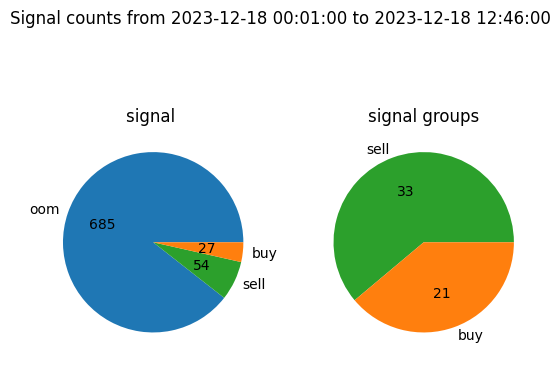

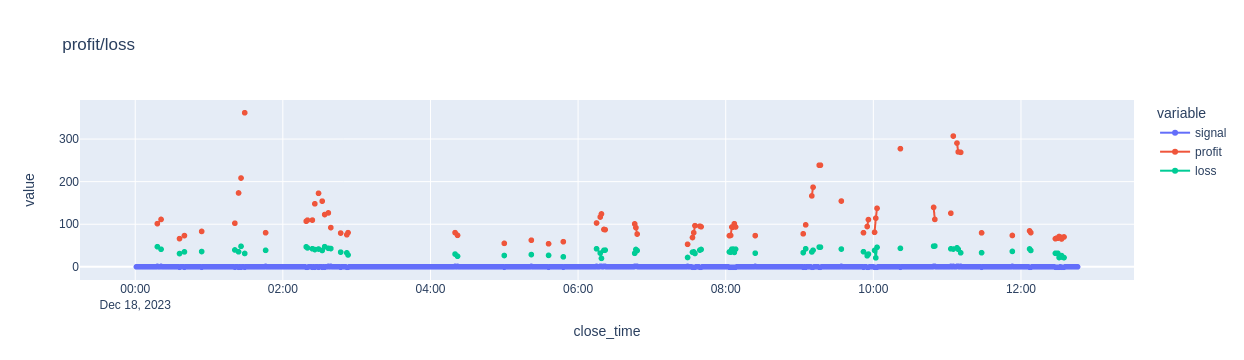

In [82]:

def calc_signal(candles, predict_window, open_ratio, min_profit_ratio, max_loss_ratio, comission_pct=0.012):
    """ Signal -1,0,1 plus extended debugging info """
    #next_candles = candles[['open', 'high', 'low', 'close', 'vol']].shift(1)

    next_candles = pd.DataFrame(index=candles.index)
    next_candles[['high', 'low']] = (candles[['high', 'low']][::-1]
                                     .rolling(predict_window).agg({'high' : 'max', 'low' : 'min'})
                                     [::-1])

    # BTC-USDT 40 000 * 1% = 400
    # BTC-USDT 40 000 * 0.012% = 40 * 0.012 = 4,8
    comission = comission_pct*0.01*2 # Order open, order close, double comission
    # Ratio to open: generate signal if profit/loss > open ratio
    #open_ratio = 1
    min_profit = candles['close']*(max(comission*2, min_profit_ratio))
    max_loss = candles['close']*max_loss_ratio
    
    # Profit / loss > open ratio considering comission and minimal profit
    profit_buy = (next_candles['high'] - candles['high']) - (candles['close']*2*comission)
    loss_buy =  (candles['high'] - next_candles['low']) + (candles['close']*2*comission)
    signal_buy = (profit_buy > 0) & ((profit_buy / loss_buy) > open_ratio)& (profit_buy > min_profit) & (loss_buy < max_loss)
    
    # Profit / loss > open ratio considering comission and minimal profit
    profit_sell = (candles['low'] - next_candles['low']) - (candles['close']*2*comission)
    loss_sell = (next_candles['high'] - candles['low']) + (candles['close']*2*comission)
    signal_sell = (profit_sell > 0) & ((profit_sell / loss_sell) > open_ratio) & (profit_sell > min_profit) & (loss_sell < max_loss)

    # Signal
    signal = pd.DataFrame(index=candles.index)
    signal['signal'] = 0  # Default to 0
    signal.loc[signal_buy & ~signal_sell, 'signal'] = 1  # Set to 1 where 'buy' is True and 'sell' is False
    signal.loc[~signal_buy & signal_sell, 'signal'] = -1  # Set to -1 where 'sell' is True and 'buy' is False

    df = signal
    # Future profit and loss
    df.loc[signal['signal']==1, 'profit'] = profit_buy
    df.loc[signal['signal']==1, 'loss'] = loss_buy
    df.loc[signal['signal']==-1, 'profit'] = profit_sell
    df.loc[signal['signal']==-1, 'loss'] = loss_sell
    return df

signal = (calc_signal(candles, 
                      predict_window = '10min', 
                      open_ratio = 2, 
                      # 0.01*0.012*2 - open+close comission 0.012%
                      # Comission is 4.8 for 40K price, ~10 for one open+close trade
                      min_profit_ratio = (0.01*0.012*2) * 5,
                      max_loss_ratio = (0.01*0.012*2) * 5)
         )
signal[signal['signal']!=0].tail(100)

# Pie plot, signals
plot_signal_counts(signal)


# Line plot, profit/loss
import plotly.express as px
import warnings
# Supress pandas+plotly warning
warnings.simplefilter(action='ignore', category=FutureWarning)
px.line(signal, title='profit/loss').update_traces(mode='lines+markers').show()

# Matplotlib profit/loss chart
# signal[signal['signal']!=0].plot(linestyle=':', marker='o', title='profit/loss')
#plt.show()



## Feature engineering


### Calculate indicators

In [91]:

from ta import trend, momentum, volume, others, volatility

def with_time_features(df: pd.DataFrame):
    # dt = df.index.to_frame()["close_time"].dt
    dt = df.index
    df["time_hour"] = dt.hour
    df["time_minute"] = dt.minute
    #df["time_second"] = dt.second
    return df

def with_ichimoku(candles: pd.DataFrame):
    ichimoku = trend.IchimokuIndicator(candles['high'], candles['low'])
    candles['ichimoku_base_line'] = ichimoku.ichimoku_base_line()
    candles['ichimoku_conversion_line'] = ichimoku.ichimoku_conversion_line()
    candles['ichimoku_a'] = ichimoku.ichimoku_a()
    candles['ichimoku_b'] = ichimoku.ichimoku_b()    
    return candles

# Apply features and indicators
candles = with_time_features(candles)
candles = with_ichimoku(candles)
candles['cci'] = trend.cci(candles['high'], candles['low'], candles['close'])
candles['adx'] = trend.adx(candles['high'], candles['low'], candles['close'])
candles['rsi'] = momentum.rsi(candles['close'])
candles['stoch'] = momentum.stoch(candles['high'], candles['low'], candles['close'])
candles['macd'] = trend.macd(candles['close'])


candles.tail()

,close_time,open_time,ticker,interval,open,high,low,close,vol,time_hour,time_minute,time_second,ichimoku_base_line,ichimoku_conversion_line,ichimoku_a,ichimoku_b,cci,adx,rsi,stoch,macd
close_time,,,,,,,,,,,,,,,,,,,,,
2023-12-18 12:42:00,2023-12-18 12:42:00,2023-12-18 12:41:00,BTC-USDT,1min,41049.4,41049.4,41037.2,41046.9,5754,12,42,0,41046.95,41045.85,41046.400,41067.85,-42.358026,20.660635,47.327432,47.421638,-6.150556
2023-12-18 12:43:00,2023-12-18 12:43:00,2023-12-18 12:42:00,BTC-USDT,1min,41046.9,41047.0,41034.3,41034.3,1472,12,43,0,41049.45,41045.85,41047.650,41067.85,-58.760601,20.194631,44.013606,34.681496,-6.906323
2023-12-18 12:44:00,2023-12-18 12:44:00,2023-12-18 12:43:00,BTC-USDT,1min,41034.2,41034.2,41021.0,41028.9,900,12,44,0,41049.45,41045.85,41047.650,41067.85,-84.185760,20.284465,42.635767,31.075269,-7.850513
2023-12-18 12:45:00,2023-12-18 12:45:00,2023-12-18 12:44:00,BTC-USDT,1min,41028.8,41028.8,41000.0,41000.0,12142,12,45,0,41049.45,41036.45,41042.950,41067.85,-111.238522,21.077866,36.118948,0.000000,-10.806211
2023-12-18 12:46:00,2023-12-18 12:46:00,2023-12-18 12:45:00,BTC-USDT,1min,41000.0,41000.0,41000.0,41000.0,0,12,46,0,41049.45,41024.70,41037.075,41067.85,-115.990078,21.814596,36.118948,0.000000,-12.998781


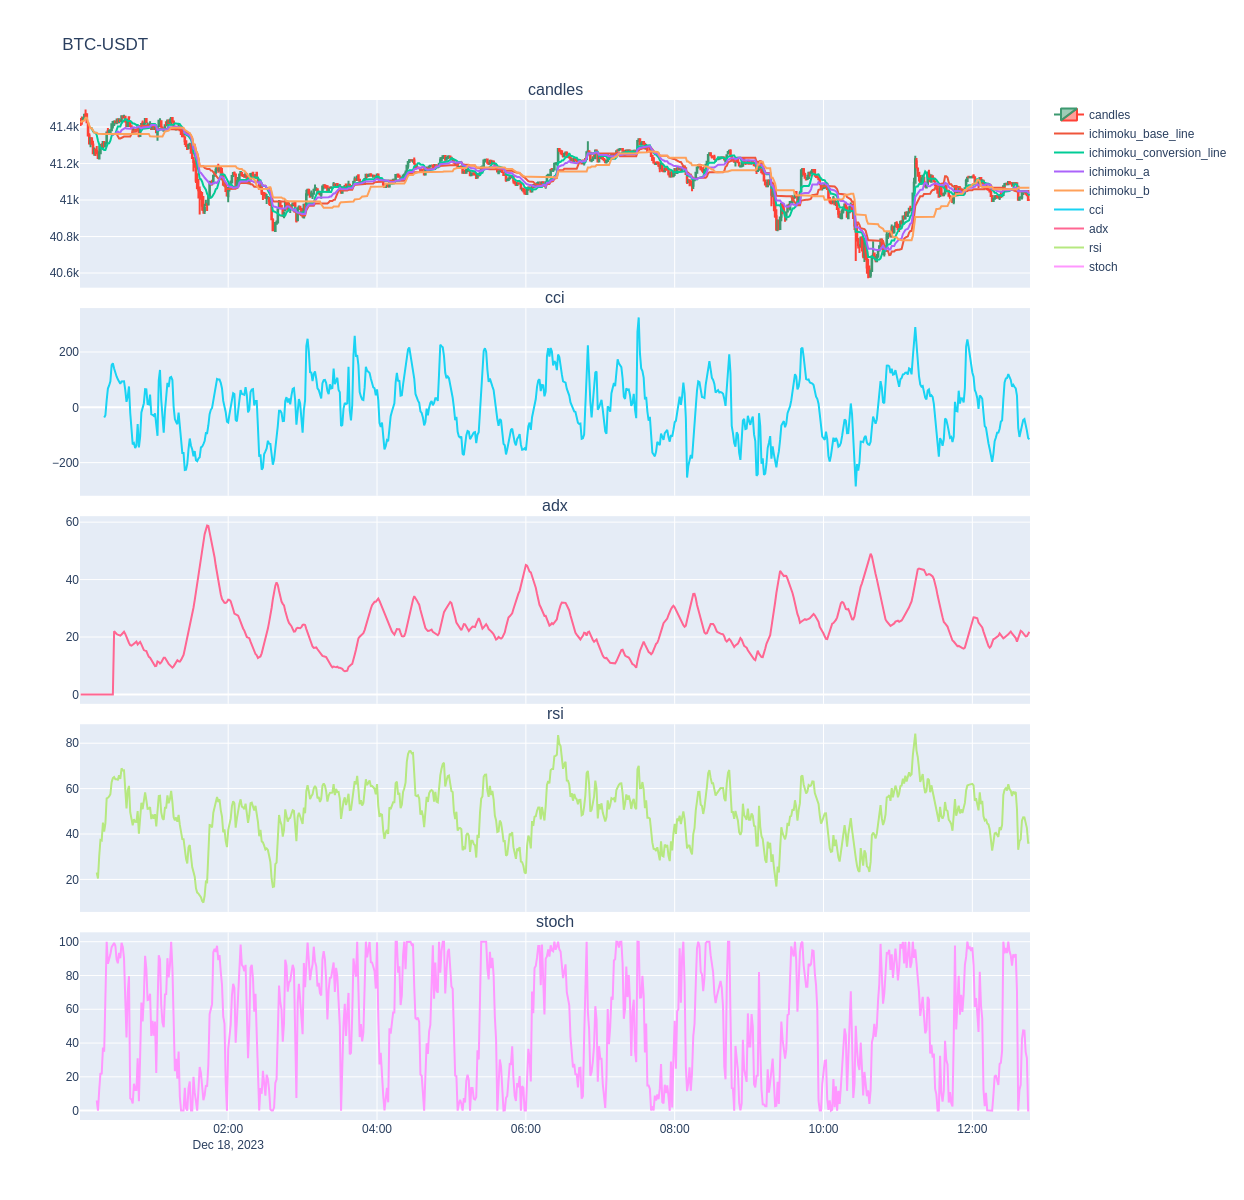

In [179]:
import plotly as py
from plotly import graph_objects as go
from plotly.subplots import make_subplots

def plot_indicators(df, extra_lines:[], extra_subplots:[]):
    fig = make_subplots(rows=len(extra_subplots)+1, cols=1, 
                        shared_xaxes=True,
                        vertical_spacing=0.02,
                        subplot_titles=['candles']+extra_subplots
                       )    
    
    # Candles
    fig.add_trace(go.Candlestick(\
                        name='candles',
                        x=df.index,\
                        open=df['open'],\
                        high=df['high'],\
                        low=df['low'],\
                        close=df['close'])
                     , row=1, col=1)

    # Other charts on candles chart
    for name in extra_lines:
        fig.add_trace(go.Scatter(name=name, x=df.index, y=df[name], mode='lines'), row=1, col=1)

    # Other subplots below candles
    for i, col in enumerate(extra_subplots):
        fig.add_trace(go.Scatter(name=col, x=df.index,y=df[col], mode='lines'), row=2+i, col=1)
    
    fig.update_layout(title=f"{candles['ticker'][0]}",
                    xaxis_rangeslider_visible=False, 
                    height=300*len(extra_subplots))
    fig.show()

ichimoku_cols = ['ichimoku_base_line', 'ichimoku_conversion_line', 'ichimoku_a', 'ichimoku_b']
indicators_cols = ['cci', 'adx', 'rsi', 'stoch']
plot_indicators(candles, 
             extra_lines=ichimoku_cols,
             extra_subplots=indicators_cols)

### Create features

In [181]:
feature_cols = ['time_hour', 'time_minute'] + ichimoku_cols + indicators_cols
features = candles[feature_cols]
features.tail()

,time_hour,time_minute,ichimoku_base_line,ichimoku_conversion_line,ichimoku_a,ichimoku_b,cci,adx,rsi,stoch
close_time,,,,,,,,,,
2023-12-18 12:42:00,12,42,41046.95,41045.85,41046.400,41067.85,-42.358026,20.660635,47.327432,47.421638
2023-12-18 12:43:00,12,43,41049.45,41045.85,41047.650,41067.85,-58.760601,20.194631,44.013606,34.681496
2023-12-18 12:44:00,12,44,41049.45,41045.85,41047.650,41067.85,-84.185760,20.284465,42.635767,31.075269
2023-12-18 12:45:00,12,45,41049.45,41036.45,41042.950,41067.85,-111.238522,21.077866,36.118948,0.000000
2023-12-18 12:46:00,12,46,41049.45,41024.70,41037.075,41067.85,-115.990078,21.814596,36.118948,0.000000
